# Deep Q-Learning for Credit Card Propensity-to-Buy Classification

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_curve, roc_auc_score
from rl.agents.dqn import DQNAgent
from rl.policy import EpsGreedyQPolicy, LinearAnnealedPolicy
from rl.memory import SequentialMemory
from rl.core import Processor
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten

import sys
sys.path.append('..')
from marketing_rl.environment.biclass_env import BiClassEnvironment, EnvMode

## Prep Data

### Prep Credit Card Data

In [2]:
data_path = 'data/Credit Card Lead Prediction/train.csv'
df = pd.read_csv(data_path)
print('total data size is', df.shape[0])


total data size is 245725


In [3]:
label_col = 'Is_Lead'
index_col = 'ID'
feat_cols = ['Gender', 'Age', 'Region_Code', 'Occupation', 'Channel_Code',
             'Vintage', 'Credit_Product', 'Avg_Account_Balance', 'Is_Active']

In [4]:
X_train, X_test, y_train, y_test = train_test_split(df[feat_cols], df[label_col], random_state=0, test_size=0.3, shuffle=True)
print('train size is', X_train.shape[0])
print('test size is', X_test.shape[0])
print('train positive {}, train negative {}'.format(sum(y_train==1),sum(y_train==0)))

train size is 172007
test size is 73718
train positive 40818, train negative 131189


In [5]:
numer_feats = ['Age', 'Vintage', 'Avg_Account_Balance']
numer_transformer = StandardScaler()


binary_feats = ['Is_Active', 'Credit_Product']
binary_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="constant", fill_value='No')), ("ordinal", OrdinalEncoder())]
)

cat_feats = ['Gender', 'Region_Code', 'Occupation', 'Channel_Code']
cat_transformer = OneHotEncoder(handle_unknown='ignore')

transformer = ColumnTransformer(
    transformers=[
        ("num", numer_transformer, numer_feats),
        ("ordinal", binary_transformer, binary_feats),
        ("cat", cat_transformer, cat_feats)
    ], sparse_threshold = 0
)

In [6]:
X_train_t = transformer.fit_transform(X_train);
X_test_t = transformer.transform(X_test)


In [7]:
pos_neg_ratio = sum(y_train==1)/sum(y_train==0)
print('[train] positive sample to negative sample is', pos_neg_ratio)


[train] positive sample to negative sample is 0.3111388912180137


### Prep Environment

In [22]:
data_x = np.array(X_train_t)
data_y = np.array(y_train)

In [23]:
env = BiClassEnvironment(data_x=data_x, data_y=data_y, pos_neg_ratio=pos_neg_ratio)

## Deep Q-Network Initalization

In [24]:
class ClassifyProcessor(Processor):
    def __init__(self, input_shape):
        super(ClassifyProcessor, self).__init__()
        self.input_shape = input_shape
        
    def process_observation(self, observation):
        return observation
    
    def process_state_batch(self, batch):
        batch.reshape((-1,)+self.input_shape)
        # batch.astype(float32)/1.
        return batch
    
    def process_reward(self, reward):
        return np.clip(reward, -1., 1.)


In [25]:
input_shape = X_train_t.shape[1:]
output_size = 2 

# define memory, processor and policy
memory = SequentialMemory(limit=1000, window_length=1)
processor = ClassifyProcessor(input_shape=input_shape)
policy = LinearAnnealedPolicy(EpsGreedyQPolicy(), attr='eps', value_max=1.,
                             value_min=.1, value_test=.05, nb_steps=10000)

# define model
model = Sequential()
model.add(Flatten(input_shape=(1,)+input_shape))
model.add(Dense(64, activation='relu'))
model.add(Dense(output_size, activation='linear'))

# define dqn agent
dqn = DQNAgent(model=model, nb_actions=output_size, policy=policy, memory=memory,
              processor=processor, nb_steps_warmup=10000, gamma=0.5, target_model_update=1000)

dqn.compile(Adam(learning_rate=.00025), metrics=['mae'])

In [26]:
dqn.fit(env, nb_steps=30000, log_interval=1000)

Training for 30000 steps ...
Interval 1 (0 steps performed)
 130/1000 [==>...........................] - ETA: 0s - reward: -0.0680

/Users/sukhumarn.a/Documents/Data Science/RL for Marketing/notebooks/virtualENV/lib/python3.9/site-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


1000/1000 [==============================] - 1s 840us/step - reward: -0.0260
119 episodes - episode_reward: -0.219 [-2.556, 6.000]

Interval 2 (1000 steps performed)
1000/1000 [==============================] - 1s 781us/step - reward: -0.0050
108 episodes - episode_reward: -0.055 [-3.178, 6.622]

Interval 3 (2000 steps performed)
1000/1000 [==============================] - 1s 697us/step - reward: 0.0068
88 episodes - episode_reward: 0.084 [-2.978, 5.689]

Interval 4 (3000 steps performed)
1000/1000 [==============================] - 1s 637us/step - reward: 0.0333
65 episodes - episode_reward: 0.492 [-3.667, 9.689]

Interval 5 (4000 steps performed)
1000/1000 [==============================] - 1s 612us/step - reward: 0.0289
62 episodes - episode_reward: 0.435 [-2.867, 13.511]

Interval 6 (5000 steps performed)
1000/1000 [==============================] - 1s 636us/step - reward: -0.0135
62 episodes - episode_reward: -0.161 [-3.467, 5.266]

Interval 7 (6000 steps performed)
1000/1000 [==

## Evaluation

In [27]:
data_test_x = np.array(X_test_t)
data_test_y = np.array(y_test)

In [28]:
test_env = BiClassEnvironment(data_x=data_test_x, data_y=data_test_y, pos_neg_ratio=pos_neg_ratio, mode=EnvMode.TEST)

In [29]:
history = dqn.test(test_env, nb_episodes=1, visualize=False)

Testing for 1 episodes ...
Episode 1: reward: 12490.193, steps: 73718


In [30]:
train_q_values = []
for state in env.data_x:
    q_val = list(dqn.compute_q_values([state]))
    train_q_values.append(q_val)

In [31]:
test_q_values = []
for state in test_env.data_x:
    q_val = list(dqn.compute_q_values([state]))
    test_q_values.append(q_val)

In [32]:
y_train_pred = np.array(train_q_values)
y_test_pred = np.array(test_q_values)

In [33]:
train_fpr, train_tpr, _ = roc_curve(y_train, y_train_pred[:, 1])
test_fpr, test_tpr, _ = roc_curve(y_test, y_test_pred[:, 1])

train_auc = roc_auc_score(y_train, y_train_pred[:, 1])
test_auc = roc_auc_score(y_test, y_test_pred[:, 1])

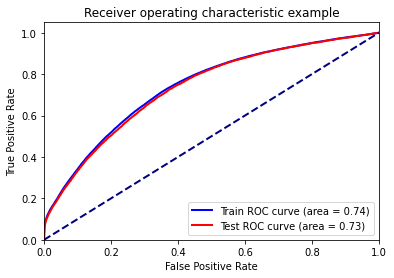

In [34]:
plt.figure()
lw = 2
plt.plot(train_fpr, train_tpr, color="b",lw=lw, label="Train ROC curve (area = %0.2f)" % train_auc)
plt.plot(test_fpr, test_tpr, color="r",lw=lw, label="Test ROC curve (area = %0.2f)" % test_auc)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic example")
plt.legend(loc="lower right")
plt.show()